In [1]:
import os

# import numpy as np
import pandas as pd 

import matplotlib as mpl 
import matplotlib.cm as cm 
import matplotlib.pyplot as plt 
import plotly.graph_objects as go
import seaborn as sns

# from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import _stop_words
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer 

import string
import re

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

# from sklearn.metrics import accuracy_score
# import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
# from sklearn.metrics import classification_report
# from sklearn import metrics

# from time import time

import spacy

from datasets import Dataset
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import DataCollatorWithPadding

os.environ["WANDB_DISABLED"] = "true"

import warnings
warnings.filterwarnings("ignore")

c:\Users\Pavel\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.DataFrame(columns=['text', 'label'])

path = 'bbc/'

for root, _, files in os.walk(path):
    for filename in files:
        with open(os.path.join(root, filename)) as f:
            text = f.read()
            current_df = pd.DataFrame({'text': [text], 'label': root.split('/')[-1]})
            df = df.append(current_df, ignore_index=True)

In [3]:
df.head()

,text,label
0,Ad sales boost Time Warner profit\n\nQuarterly...,business
1,Dollar gains on Greenspan speech\n\nThe dollar...,business
2,Yukos unit buyer faces loan claim\n\nThe owner...,business
3,High fuel prices hit BA's profits\n\nBritish A...,business
4,Pernod takeover talk lifts Domecq\n\nShares in...,business


In [4]:
## Uncomment it to download necessary packages
# ! python -m spacy download en_core_web_sm
# import nltk
# nltk.download(['wordnet', 'omw-1.4'])

nlp = spacy.load('en_core_web_sm')

stopwords = _stop_words.ENGLISH_STOP_WORDS
lemmatizer = WordNetLemmatizer()

def clean(doc):
    text_no_namedentities = []
    document = nlp(doc)
    ents = [e.text for e in document.ents]
    for item in document:
        if item.text in ents:
            pass
        else:
            text_no_namedentities.append(item.text)
    doc = (" ".join(text_no_namedentities))

    doc = doc.lower().strip()
    doc = doc.replace("</br>", " ") 
    doc = doc.replace("-", " ") 
    doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit() ])
    doc = " ".join([token for token in doc.split() if token not in stopwords and len(token)>3])    
    doc = "".join([lemmatizer.lemmatize(word) for word in doc])
    return doc

In [5]:
clean(df['text'][0])

'sales boost time warner profit profits media giant jumped months december year earlier firm biggest investors benefited sales high speed internet connections higher advert sales said fourth quarter sales rose profits buoyed gains offset profit warner bros users time warner said owns search engine internet business mixed fortunes lost subscribers fourth quarter profits lower preceding quarters company said underlying profit exceptional items rose stronger internet advertising revenues hopes increase subscribers offering online service free internet customers sign existing customers high speed broadband restate results following probe securities exchange commission close concluding time warner fourth quarter profits slightly better analysts expectations film division profits slump helped office flops alexander catwoman sharp contrast year earlier final film lord trilogy boosted results year posted profit performance revenues grew financial performance strong meeting exceeding year objec

In [6]:
cleaned_df = df.copy()
cleaned_df['text'] = cleaned_df['text'].apply(clean)
cleaned_df.head()

,text,label
0,sales boost time warner profit profits media g...,business
1,dollar gains speech dollar highest level euro ...,business
2,unit buyer faces loan claim owners embattled g...,business
3,high fuel prices profits british airways blame...,business
4,takeover talk lifts domecq shares drinks food ...,business


In [7]:
docs = list(cleaned_df['text'])
tfidf_vectorizer = TfidfVectorizer(use_idf=True, max_features = 20000) 
tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform(docs)
docs = tfidf_vectorizer_vectors.toarray()

In [8]:
label2id = {lbl: i for i, lbl in enumerate(cleaned_df['label'].unique())}
id2label = {v: k for k, v in label2id.items()}

In [9]:
X = docs 
y = cleaned_df['label'].map(label2id)
print(X.shape, y.shape)

(2225, 20000) (2225,)


In [10]:
SEED = 52
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1780, 20000) (1780,)
(445, 20000) (445,)


In [11]:
dt = DecisionTreeClassifier(random_state=SEED)
%time dt.fit(X_train, y_train)

y_pred_train = dt.predict(X_train)
y_pred_test = dt.predict(X_test)
p, r, f1, _ = precision_recall_fscore_support(y_test, y_pred_test, average='macro')
print("\nTraining Accuracy score:", accuracy_score(y_train, y_pred_train))
print("\nTesting Accuracy score:", accuracy_score(y_test, y_pred_test))
print("Testing Precision:", p)
print("Testing Recall", r)
print("Testing F1 score:", f1)


Wall time: 4.76 s

Training Accuracy score: 1.0

Testing Accuracy score: 0.8157303370786517
Testing Precision: 0.815099455784553
Testing Recall 0.8149834479246243
Testing F1 score: 0.813829108033367


In [12]:
# Inference

idx = 50
x_inference = X_test[idx]
y_pred_inference = dt.predict([x_inference])
y_true = y[idx]
print()
print(f'Predicted class: {id2label[int(y_pred_inference)]}')
print(f'True class: {id2label[y_true]}')


Predicted class: business
True class: business


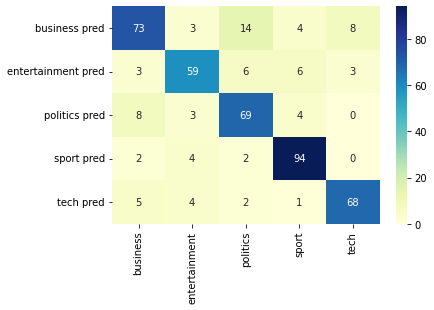

In [13]:
cm = confusion_matrix(y_test, y_pred_test)
# print('Confusion matrix\n', cm)

cm_matrix = pd.DataFrame(data=cm, columns=label2id.keys(), 
                        index=[key+' pred' for key in label2id.keys()])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

# BERT

In [25]:
df_bert = cleaned_df.copy()

df_bert['label'] = df_bert['label'].map(label2id)

custom_dataset = Dataset.from_pandas(df_bert).train_test_split(test_size=0.2)

In [26]:
custom_dataset['train'][0]

{'text': 'proposes overhaul welsh rugby union wants restructure northern hemisphere separate blocks start celtic league followed heineken nations moved week break proposes month period away home international matches chairman david pickering said structure problems player availability club country added feel sure spectator respond impetus high intensity rugby played continuously fragmented timetable currently operation equally suspect sponsors prefer sustained continuous tournament hopefully broadcasters enjoy increased exposure moving nations traditional beginning ensure better weather conditions stimulate greater games generally provide increased skills competition attract greater spectator viewing pickering argued plan international rugby board month plans drawn independent consultants global integrated discussed pickering added early days number caveats associated revenue broadcasters extremely important good plan judged merits',
 'label': 3}

In [27]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True)

loading configuration file config.json from cache at C:\Users\Pavel/.cache\huggingface\hub\models--distilbert-base-uncased\snapshots\043235d6088ecd3dd5fb5ca3592b6913fd516027\config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.22.2",
  "vocab_size": 30522
}

loading file vocab.txt from cache at C:\Users\Pavel/.cache\huggingface\hub\models--distilbert-base-uncased\snapshots\043235d6088ecd3dd5fb5ca3592b6913fd516027\vocab.txt
loading file tokenizer.json from cache at C:\Users\Pavel/.cache\huggingface\hub\models--dis

In [28]:
tokenized_dataset = custom_dataset.map(preprocess_function, batched=True)

100%|██████████| 1/1 [00:00<00:00,  6.69ba/s]


In [29]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=len(id2label))

loading configuration file config.json from cache at C:\Users\Pavel/.cache\huggingface\hub\models--distilbert-base-uncased\snapshots\043235d6088ecd3dd5fb5ca3592b6913fd516027\config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.22.2",
  "vocab_size": 30522
}

loading weights file pytorch_

In [30]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    Precision, Recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': Precision,
        'Recall': Recall
    }

In [31]:
# from torch import cuda
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    # fp16= cuda.is_available()
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics= compute_metrics
)

trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 1780
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization s

{'loss': 0.2457, 'learning_rate': 1.1031390134529149e-05, 'epoch': 2.24}


Model weights saved in ./results\checkpoint-500\pytorch_model.bin
tokenizer config file saved in ./results\checkpoint-500\tokenizer_config.json
Special tokens file saved in ./results\checkpoint-500\special_tokens_map.json
 90%|████████▉ | 1000/1115 [05:25<00:37,  3.03it/s]Saving model checkpoint to ./results\checkpoint-1000
Configuration saved in ./results\checkpoint-1000\config.json


{'loss': 0.0177, 'learning_rate': 2.062780269058296e-06, 'epoch': 4.48}


Model weights saved in ./results\checkpoint-1000\pytorch_model.bin
tokenizer config file saved in ./results\checkpoint-1000\tokenizer_config.json
Special tokens file saved in ./results\checkpoint-1000\special_tokens_map.json
100%|██████████| 1115/1115 [06:05<00:00,  3.94it/s]

Training completed. Do not forget to share your model on huggingface.co/models =)


100%|██████████| 1115/1115 [06:05<00:00,  3.05it/s]

{'train_runtime': 365.7002, 'train_samples_per_second': 24.337, 'train_steps_per_second': 3.049, 'train_loss': 0.11907247075050936, 'epoch': 5.0}


TrainOutput(global_step=1115, training_loss=0.11907247075050936, metrics={'train_runtime': 365.7002, 'train_samples_per_second': 24.337, 'train_steps_per_second': 3.049, 'train_loss': 0.11907247075050936, 'epoch': 5.0})

In [32]:
q = trainer.evaluate(eval_dataset=tokenized_dataset['test'])
pd.DataFrame(q, index=["test"]).iloc[:,:5]

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 445
  Batch size = 8
100%|██████████| 56/56 [00:06<00:00,  8.03it/s]


,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
test,0.181917,0.970787,0.970656,0.972231,0.969977


In [33]:

device = "cuda"# if cuda.is_available() else "cpu"
def get_prediction(text):
    inputs = tokenizer(text, padding=True, truncation=True, max_length=250, return_tensors="pt").to(device)
    outputs = model(inputs["input_ids"].to(device),inputs["attention_mask"].to(device))
    probs = outputs[0].softmax(1)
    return probs, probs.argmax()

In [34]:
# Inference
idx = 50
example = custom_dataset['test'][idx]
text = example['text']
label = example['label']


prediction_id = get_prediction(text)[1].item()

print(f'Predicted class: {id2label[int(prediction_id)]}')
print(f'True class: {id2label[label]}')

Predicted class: entertainment
True class: entertainment


Вывод: Трансформер явно лучше классических подходов)